In [52]:
from PIL import Image
import numpy as np
from iminuit import Minuit
from scipy.signal import savgol_filter
import pandas as pd

import matplotlib

import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams.update({'font.size': 18})

In [2]:
def plot_grad(grad, column=0):
    y = grad[:, 2000]
    y[np.isinf(y)] = 0

    yhat = savgol_filter(y, 101, 3)

    yhathat = np.diff(yhat)
    m = np.argmax(yhathat)

    plt.axvline(x=m, c='y', ls='--')

    plt.scatter(np.arange(grad.shape[0]), y)
    plt.plot(np.arange(grad.shape[0]), yhat, c='k')

    plt.show()

In [3]:
def find_break(image, y_min=0, y_max=-1):
    grad = np.log10(abs(np.gradient(image.sum(axis=2), axis=0)))
    grad[np.isinf(grad)] = 0
    
    breaks = []
    for i in range(image.shape[1]):
    
        y = grad[:, i]
        y[np.isinf(y)] = 0

        yhat = savgol_filter(y, 101, 3)

        yhathat = np.diff(yhat)
        m = np.argmax(yhathat[y_min:y_max])

        breaks += [m+y_min]
        
    return np.array(breaks)

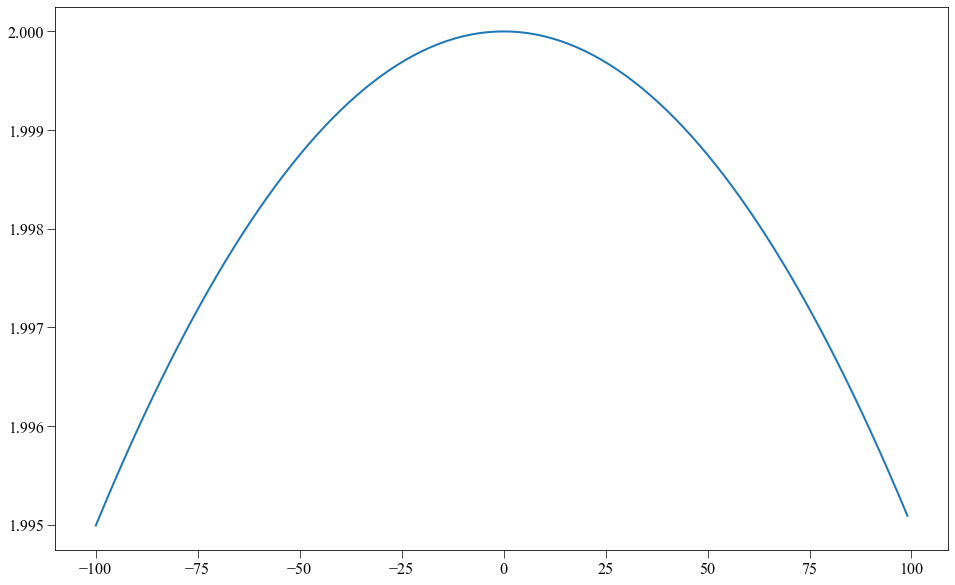

In [4]:
def intrinsic_transform(world_coords, f=1, px=1, py=1, x0=0, y0=0):
    Mi = np.array([
        [float(f)/px, 0, x0, 0],
        [0, float(f)/py, y0, 0],
        [0, 0, 1, 0]
    ])
        
    # todo allow for shear/etc.    
    
    camera_coords = []
    for i in range(len(world_coords)):
        camera_coords += [Mi @ world_coords[i, :]]
    camera_coords = np.array(camera_coords)
    
    return camera_coords


def extrinsic_transform(world_coords,
                        theta_x=0, theta_y=0, theta_z=0,
                        origin_x=0, origin_y=0, origin_z=0):
    
    """
    origin_x (world coords center in camera coords)
    """
    
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    rotation = Rx @ Ry @ Rz
    
    translation = np.array([origin_x, origin_y, origin_z])
    
    # see https://en.wikipedia.org/wiki/Camera_resectioning
    transform = np.zeros((4, 4))
    transform[:3, :3] = rotation
    transform[:3, 3] = translation
    transform[3, 3] = 1
        
    camera_coords = []
    for i in range(len(world_coords)):
        camera_coords += [transform @ world_coords[i, :]]
    camera_coords = np.array(camera_coords)
    
    return camera_coords


def limb_arc(x, r, h=1,
             method='resection', screen_dist=1,
             f=1, px=1, py=1, x0=0, y0=0,
             theta_x=0, theta_y=0, theta_z=0,
             origin_x=0, origin_y=0, origin_z=0
             ):
    
    # diffraction correction?
#     r = r * 1.2
        
    d = np.sqrt(h**2 + 2*h*r)
    theta = np.arccos(r / (r + h))

    xdcostheta = np.clip(x / (d * np.cos(theta)), -1, 1) # to avoid out of bounds
#     xdcostheta = x / (d * np.cos(theta))
    y_world = d * np.cos(np.arcsin(xdcostheta)) * np.sin(theta)
                   
    if method == 'screen':
        y_camera = y_world * screen_dist / np.sqrt(d**2 - y_world**2)
    elif method == 'resection':
        x_world = d * np.sin(np.arcsin(xdcostheta)) * np.cos(theta)
        z_world = d * np.cos(np.arcsin(xdcostheta)) * np.cos(theta)
        
        world_coords = np.ones((len(x), 4))
        world_coords[:, 0] = x_world
        world_coords[:, 1] = y_world
        world_coords[:, 2] = z_world
        # todo worth a 3d scatter demo of world coords?
        
        camera_coords = extrinsic_transform(world_coords,
                                            theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
                                            origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)
        camera_coords = intrinsic_transform(camera_coords, f=f, px=px, py=py,
                                            x0=x0, y0=y0)
        
        y_camera = camera_coords[:, 1]
    
    return y_camera

y = limb_arc(np.arange(-100, 100), 1e6, method='resection')
plt.plot(np.arange(-100, 100), y)
plt.show()

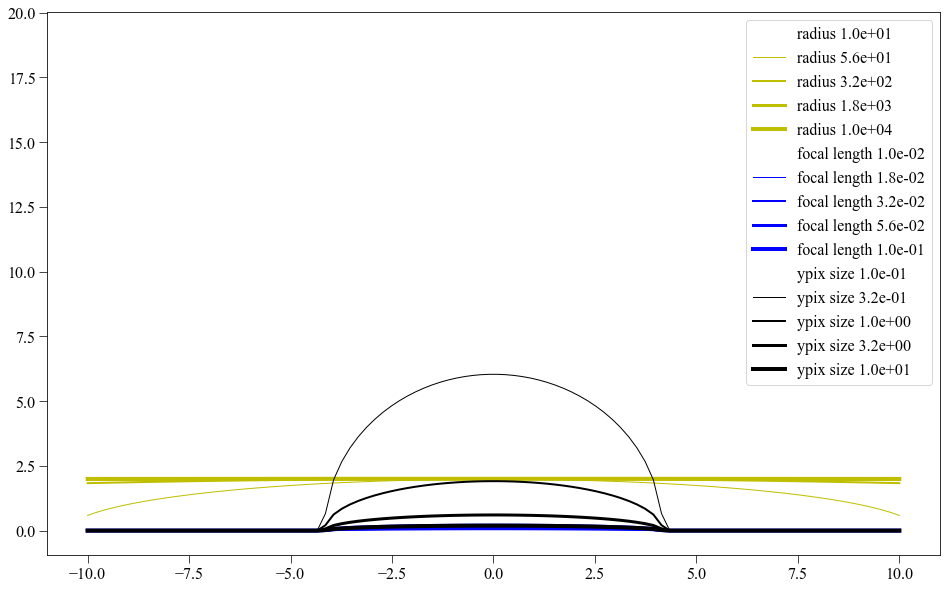

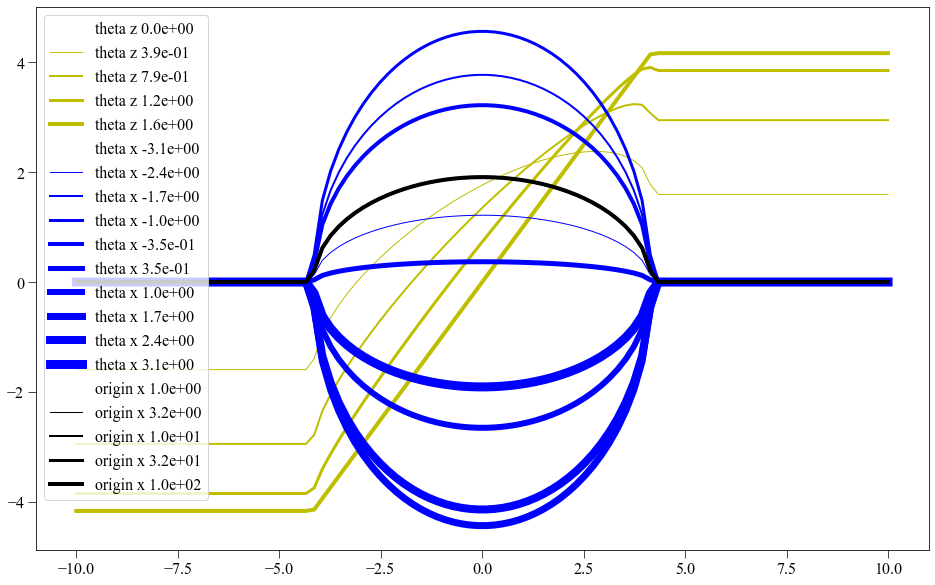

In [5]:
x = np.linspace(-10, 10, 100)

for i, r in enumerate(np.logspace(1, 4, num=5)):
#     y = limb_arc(x, r, h=1, method='screen', screen_dist=1)
    y = limb_arc(x, r, method='resection', f=1, px=1, py=1, x0=0, y0=0)
    plt.plot(x, y, label=f'radius {r:.1e}', c='y', lw=i)
    
for i, r in enumerate(np.logspace(-2, -1, num=5)):
#     y = limb_arc(x, r=10, h=1, method='screen', screen_dist=r)
    y = limb_arc(x, r=10, method='resection', f=r, px=1, py=1, x0=0, y0=0)
    plt.plot(x, y, label=f'focal length {r:.1e}', c='b', lw=i)
    
for i, r in enumerate(np.logspace(-1, 1, num=5)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=r, x0=0, y0=0)
    plt.plot(x, y, label=f'ypix size {r:.1e}', c='k', lw=i)
    
plt.legend()
plt.show()
    
for i, theta in enumerate(np.linspace(0, np.pi/2, num=5)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=1, x0=0, y0=0,
                 theta_x=0, theta_y=0, theta_z=theta,
                 origin_x=0, origin_y=0, origin_z=0)
    plt.plot(x, y, label=f'theta z {theta:.1e}', c='y', lw=i)    

for i, theta in enumerate(np.linspace(-np.pi, np.pi, num=10)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=1, x0=0, y0=0,
                 theta_x=theta, theta_y=0, theta_z=0,
                 origin_x=0, origin_y=0, origin_z=0)
    plt.plot(x, y, label=f'theta x {theta:.1e}', c='b', lw=i) 
    
for i, d in enumerate(np.logspace(0, 2, num=5)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=1, x0=0, y0=0,
                 theta_x=0, theta_y=0, theta_z=0,
                 origin_x=d, origin_y=0, origin_z=0)
    plt.plot(x, y, label=f'origin x {d:.1e}', c='k', lw=i) 
    
plt.legend()
plt.show()

In [6]:
iss_h = 418*1000 # up to 415-421km [418.552]
earth_r = 6.3e6

In [7]:
img = Image.open('demo/iss040e129950.jpg')
arry = img.getdata()
im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)
im_arr = im_arr.reshape((img.size[1], img.size[0], 3)) 

/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_18816/603171426.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)


In [8]:
breaks = find_break(im_arr)

/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_18816/2206104159.py:2: RuntimeWarning: divide by zero encountered in log10
  grad = np.log10(abs(np.gradient(image.sum(axis=2), axis=0)))


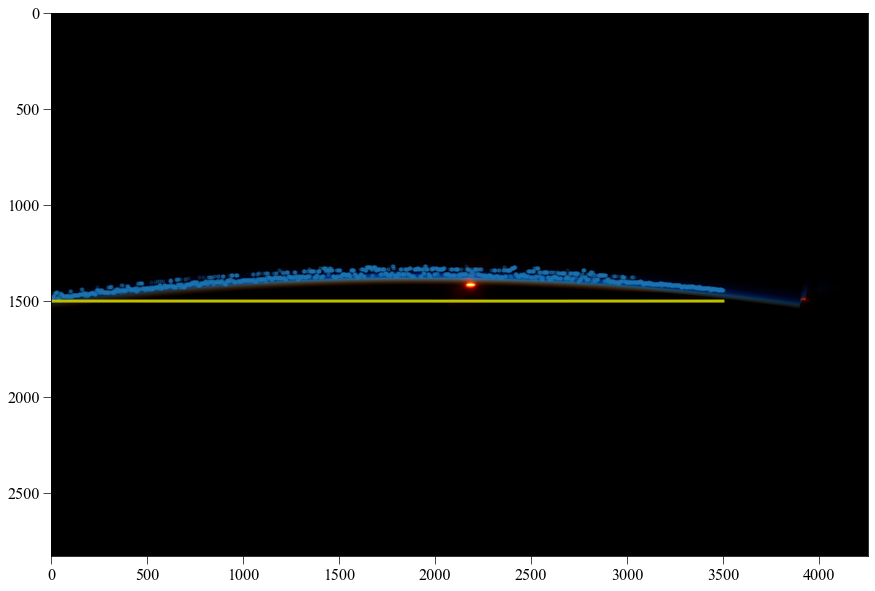

In [9]:
target = breaks[:3500]
x = np.arange(len(target))

# x = np.arange(im_arr.shape[1])
xc = x - int(len(x)*0.5)

y = limb_arc(xc, r=6.3e6, h=1) + 1500
plt.plot(x, y, c='y', lw=3)
plt.scatter(x, target, alpha=0.2, s=10)

plt.imshow(im_arr)
plt.show()

In [102]:
dict(accepted.loc[0])

{'r': 7299104.464677976,
 'h': 419714.0827806502,
 'f': 4.895215367873364,
 'px': 3.755460419550189,
 'py': 4.517751746182327,
 'x0': 73.70341834703376,
 'y0': 0.38571341546929716,
 'theta_x': 0.8492289736938918,
 'theta_y': -1.0479108197510998,
 'theta_z': -0.30450804616724625,
 'origin_x': -83.58382252022376,
 'origin_y': -79.37811844974554,
 'origin_z': 40.158361898312535}

In [124]:
lims = m.limits.to_dict()
bounds = [lims[key] for key in lims]
bounds

[(100000.0, 100000000.0),
 (-inf, inf),
 (0.0, inf),
 (0.0, inf),
 (0.0, inf),
 (-inf, inf),
 (-inf, inf),
 (-3.141592653589793, 3.141592653589793),
 (-inf, inf),
 (-3.141592653589793, 3.141592653589793),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf)]

In [128]:
from scipy.optimize import minimize

In [310]:
lims

{'r': (100000.0, 100000000.0),
 'h': (-inf, inf),
 'f': (0.0, inf),
 'px': (0.0, inf),
 'py': (0.0, inf),
 'x0': (-inf, inf),
 'y0': (-inf, inf),
 'theta_x': (-3.141592653589793, 3.141592653589793),
 'theta_y': (-inf, inf),
 'theta_z': (-3.141592653589793, 3.141592653589793),
 'origin_x': (-inf, inf),
 'origin_y': (-inf, inf),
 'origin_z': (-inf, inf)}

In [254]:
lims

{'r': (100000.0, 100000000.0),
 'h': (-inf, inf),
 'f': (0.0, inf),
 'px': (0.0, inf),
 'py': (0.0, inf),
 'x0': (-inf, inf),
 'y0': (-inf, inf),
 'theta_x': (-3.141592653589793, 3.141592653589793),
 'theta_y': (-inf, inf),
 'theta_z': (-3.141592653589793, 3.141592653589793),
 'origin_x': (-inf, inf),
 'origin_y': (-inf, inf),
 'origin_z': (-inf, inf)}

In [407]:
truncated_init

{'r': 6300000.0,
 'h': 418000,
 'f': 1,
 'py': 0.39719918367346935,
 'y0': 0,
 'theta_x': 3.141592653589793,
 'theta_z': 0,
 'origin_y': 809996}

6321992292.535934
6321992292.535934


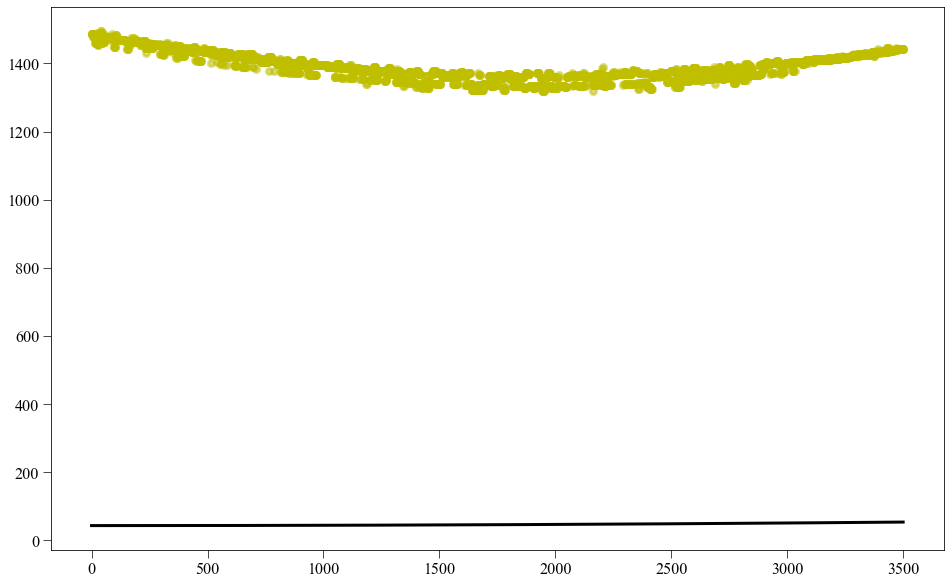

In [408]:
target = breaks[:3500]
x = np.arange(len(target))

truncated_init = {'r': earth_r, #6300000,
                  'h': iss_h,
                  'f': 1,
                  'py': 0.1, #0.003,
                  'y0': 0,
                  'theta_x': np.pi,
                  'theta_z': 0, #0.0003,
                  'origin_y': 809996
#                   'origin_y': np.sqrt(2*6300000*418000 + 418000**2)
                 }

full_init = {'r': earth_r,
        'h': iss_h,
        'f': 1,
        'px': 1,
        'py': 0.003,
        'x0': 0,
        'y0': 0,
        'theta_x': 3.141592653589793,
        'theta_y': 0,
        'theta_z': 0.0003,
        'origin_x': 0,
        'origin_y': 809996,
        'origin_z': 0}


lims = {'r': (1000000.0, 10000000.0),
        'h': (0, 1000000),
        'f': (0.0, np.inf),
        'px': (1e-5, 1),
        'py': (1e-5, 1),
        'x0': (-np.inf, np.inf),
        'y0': (-np.inf, np.inf),
        'theta_x': (-np.pi, np.pi),
        'theta_y': (0, 0),
        'theta_z': (-np.pi, np.pi),
        'origin_x': (-np.inf, np.inf),
        'origin_y': (-np.inf, np.inf),
        'origin_z': (-np.inf, np.inf)
       }


def unpack_parameters(params, template):    
    return {key:params[i] for i,key in enumerate(template)}


class CostFunction:
    def __init__(self, x, target, function, fit_template, full_template):
        self.function = function
        self.fit_template = fit_template
        self.full_template = full_template
        self.x = x
        self.target = target
        
    def cost(self, params):
        
        if type(params) == np.ndarray:
            kwargs = self.full_template.copy()
            kwargs.update(unpack_parameters(list(params), self.fit_template))
        else:
            kwargs = params
                
        y_pred = self.function(self.x, **kwargs)
        
        cost = np.sum(pow(y_pred - self.target, 2))
        
        return cost
    
    def evaluate(self, params):
        
        kwargs = self.full_template.copy()
        if type(params) == np.ndarray:
            kwargs.update(unpack_parameters(list(params), self.fit_template))
        else:
            kwargs.update(params)
                
        y_pred = self.function(self.x, **kwargs)
        
        return y_pred
    
cost_function = CostFunction(x, target, limb_arc, truncated_init, full_init)
    
print(cost_function.cost(truncated_init))
print(cost_function.cost(np.array(list(truncated_init.values()))))
    

y = cost_function.evaluate(truncated_init)
    
# rough guess
plt.plot(x, y, lw=3, c='k')
plt.scatter(x, target, c='y', lw=3, alpha=0.5)
plt.show()

In [409]:
# results = minimize(cost_function.cost, np.array(list(bad_init.values())),
#                    method='L-BFGS-B', bounds=[lims[key] for key in init], options={'maxiter':10000})
# results = minimize(cost_function.cost, np.array(list(init.values())),
#                    method='POWELL', bounds=[lims[key] for key in init], options={'maxiter':10000})
results = minimize(cost_function.cost, np.array(list(truncated_init.values())),
                   method='Nelder-Mead', bounds=[lims[key] for key in truncated_init],
                   options={'maxiter':10000})
results

 final_simplex: (array([[ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,
         4.04060753e-03, -1.05684923e-04,  3.14159265e+00,
         3.18200741e-04,  8.05528515e+05],
       [ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,
         4.04060754e-03, -1.05684923e-04,  3.14159265e+00,
         3.18200741e-04,  8.05528515e+05],
       [ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,
         4.04060756e-03, -1.05684923e-04,  3.14159265e+00,
         3.18200741e-04,  8.05528515e+05],
       [ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,
         4.04060754e-03, -1.05684923e-04,  3.14159265e+00,
         3.18200741e-04,  8.05528515e+05],
       [ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,
         4.04060755e-03, -1.05684923e-04,  3.14159265e+00,
         3.18200741e-04,  8.05528515e+05],
       [ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,
         4.04060754e-03, -1.05684923e-04,  3.14159265e+00,
         3.18200742e-04,  8.05528515e+05],
       [ 6.447247

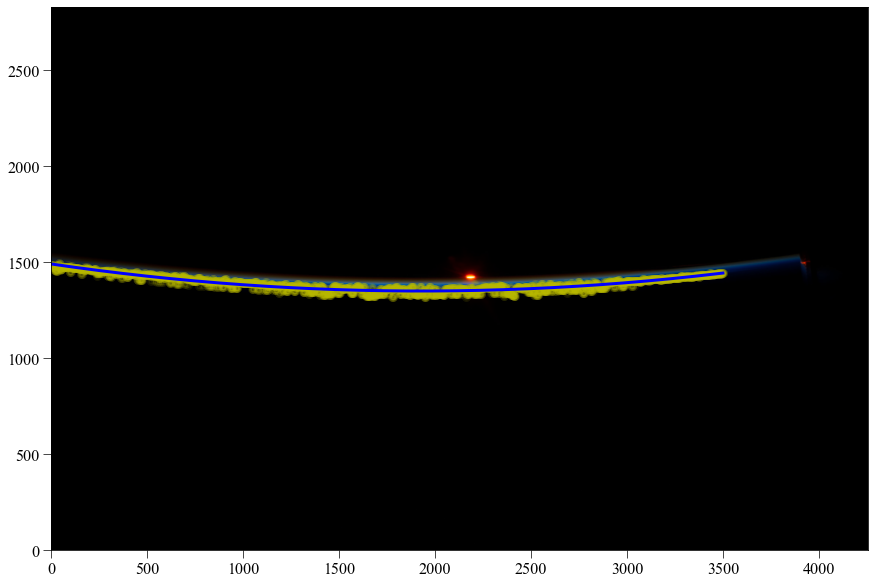

In [410]:
y = cost_function.evaluate(results.x)

plt.imshow(im_arr, origin='lower')
plt.plot(np.arange(len(target)), y, lw=3, c='b')
plt.scatter(np.arange(len(target)), target, c='y', lw=3, alpha=0.1)

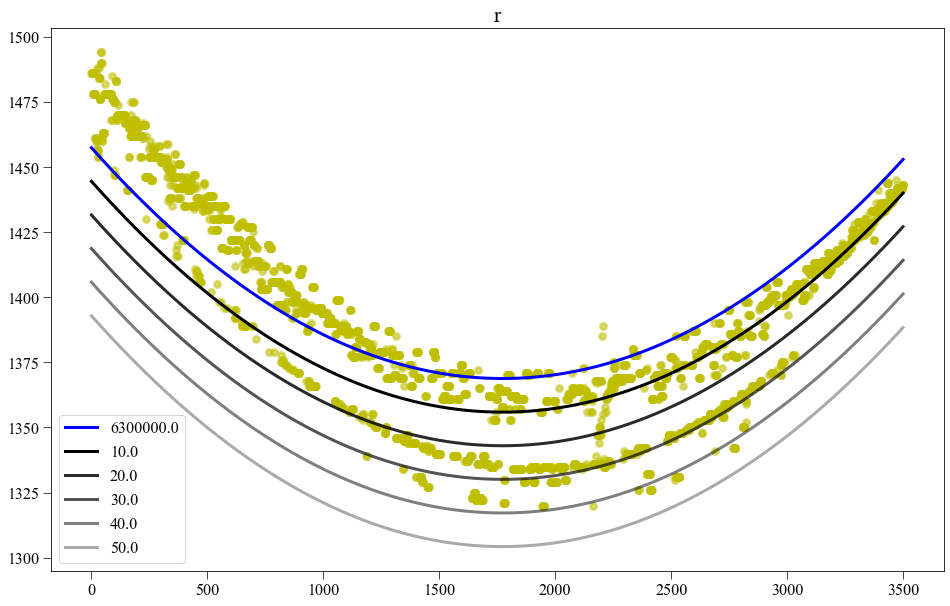

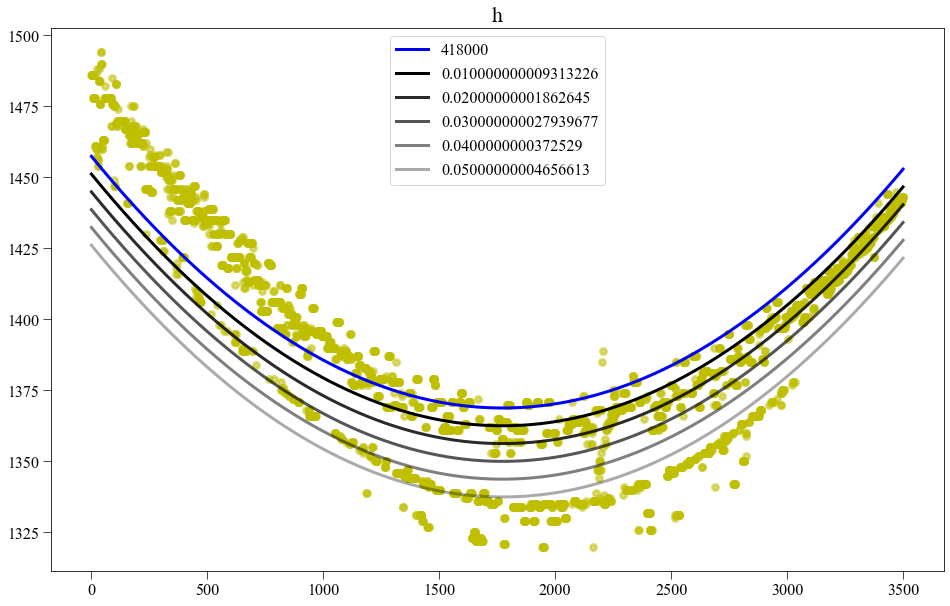

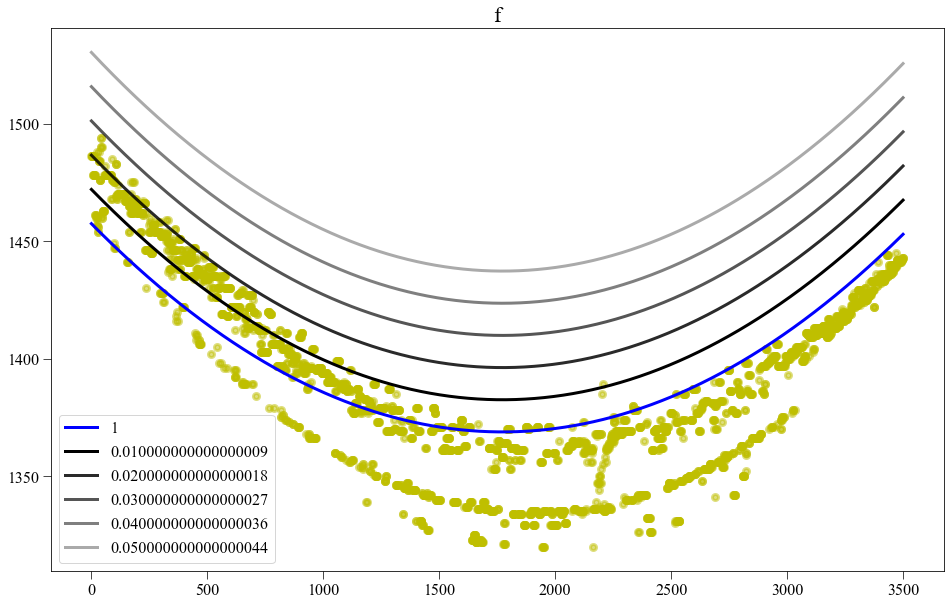

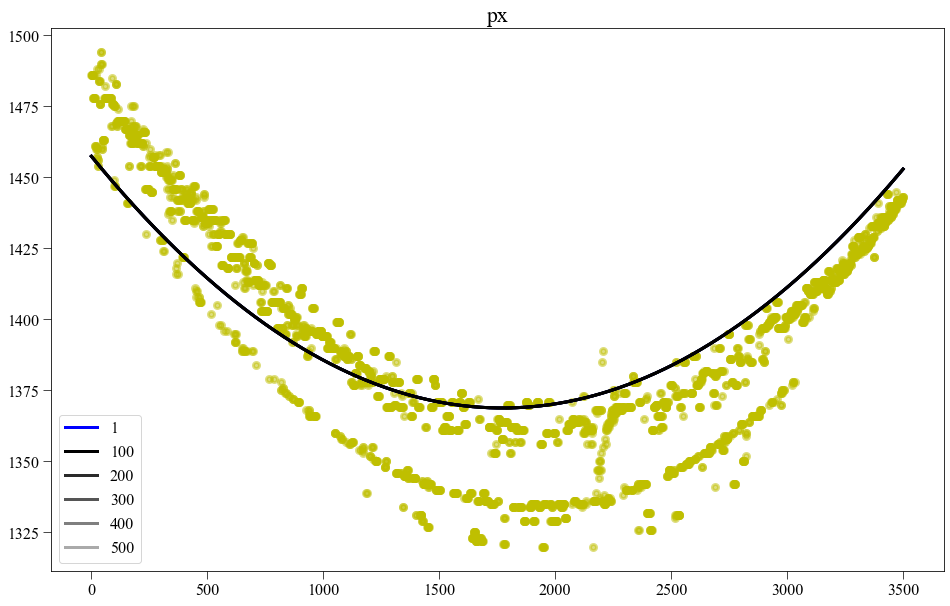

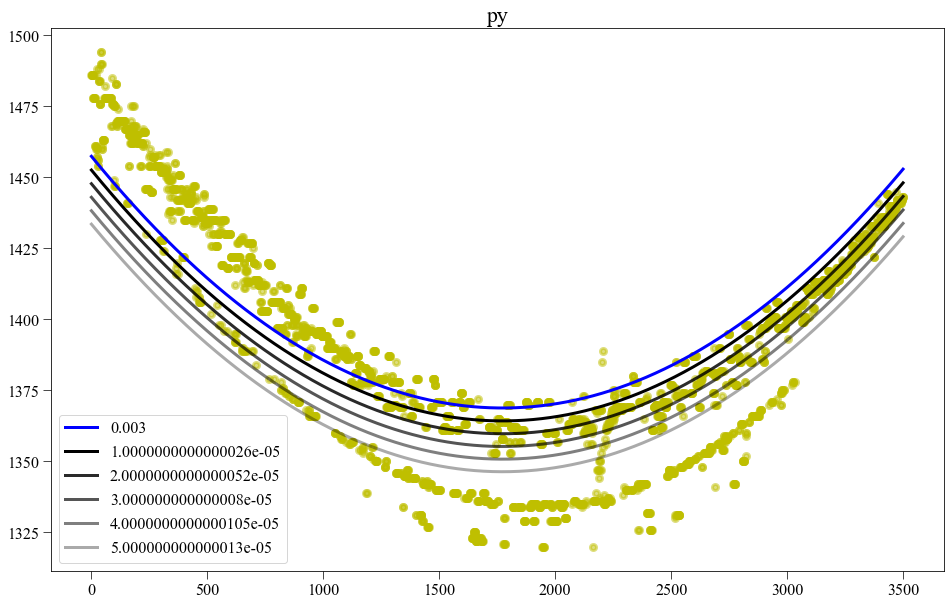

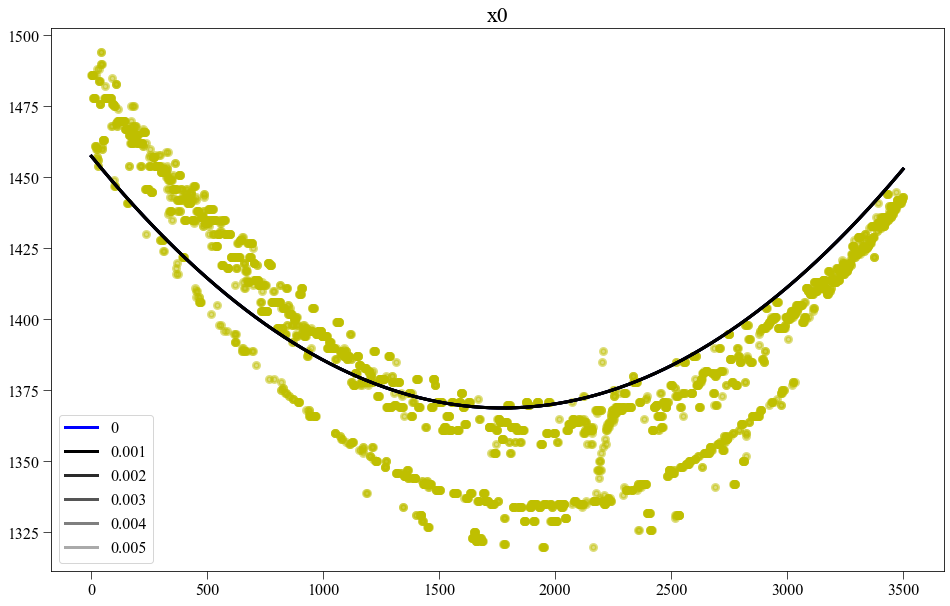

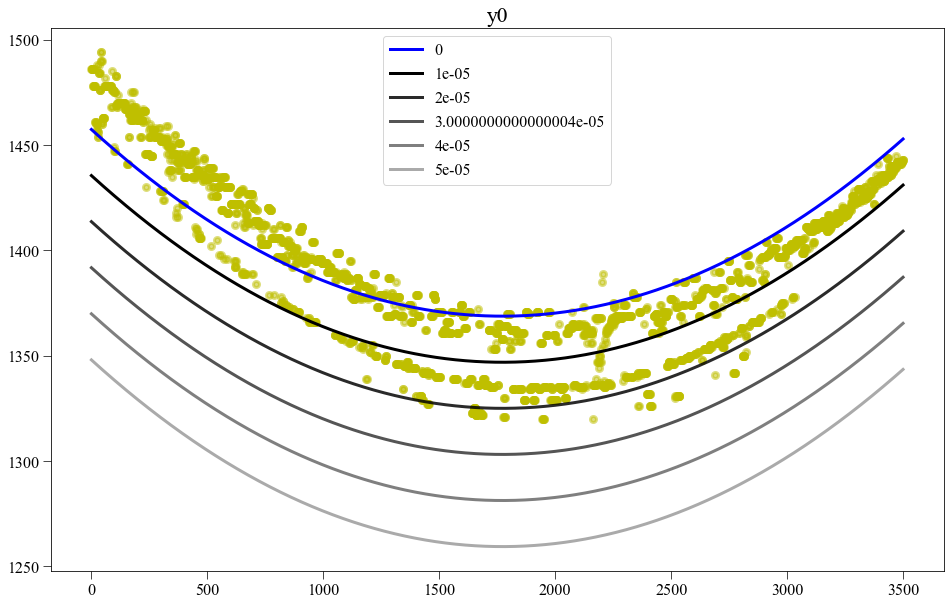

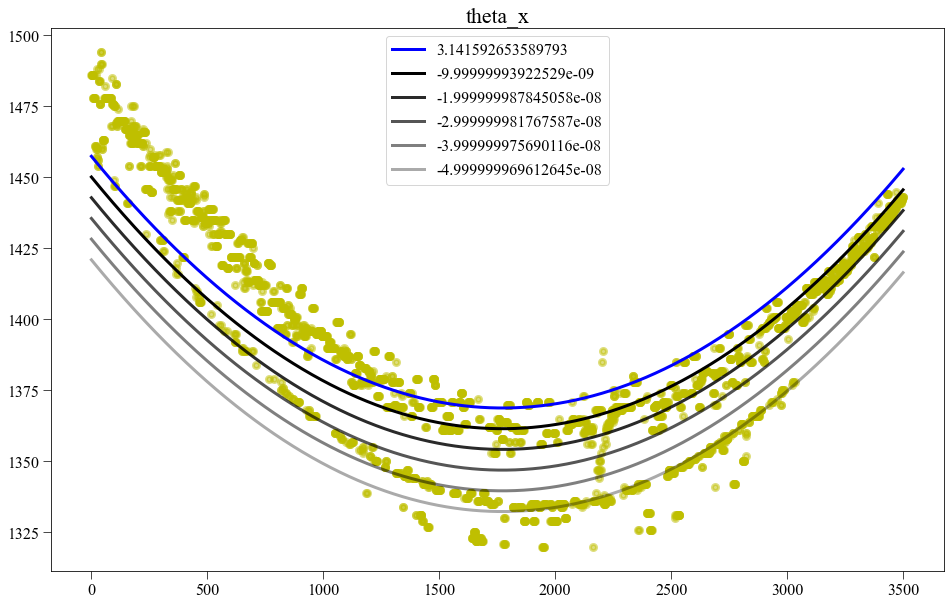

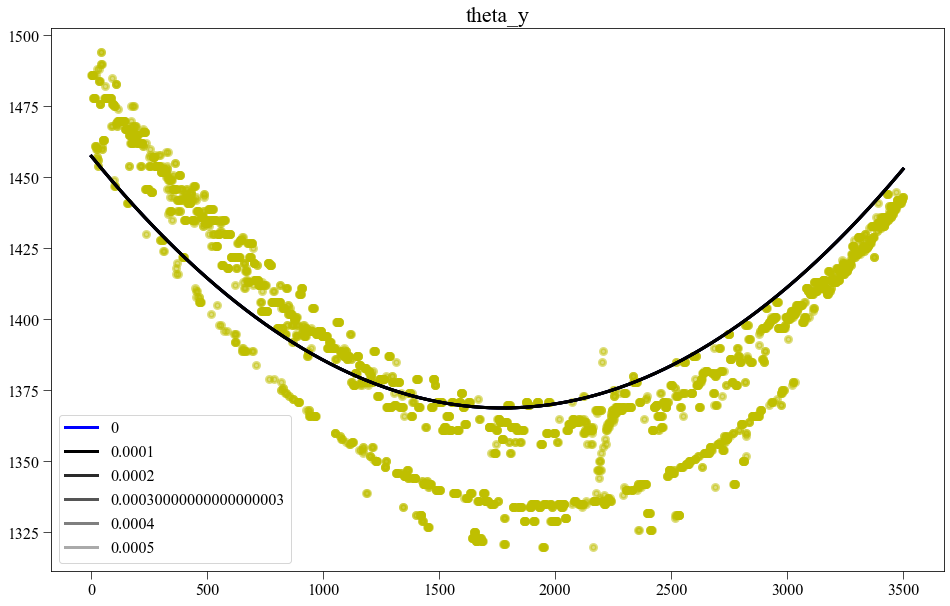

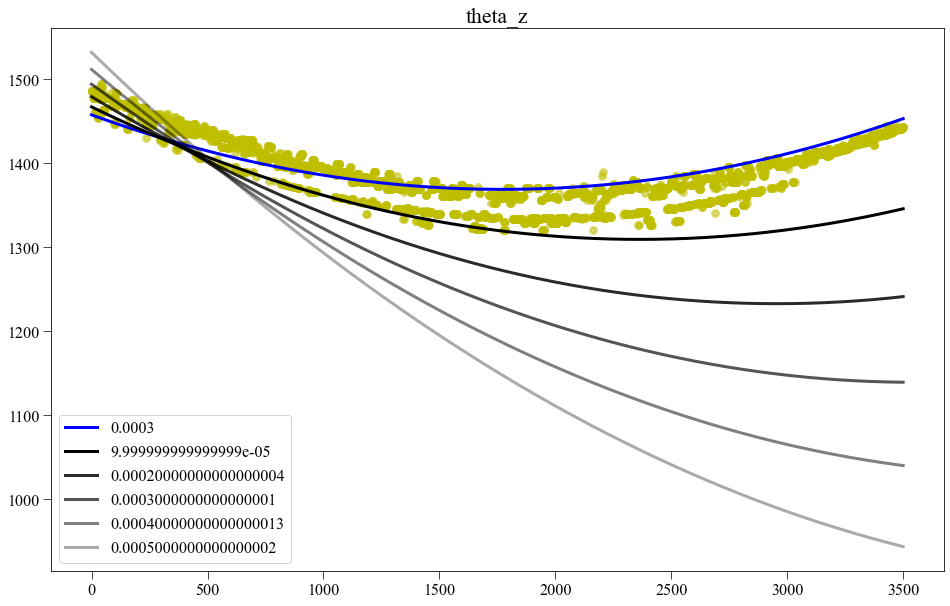

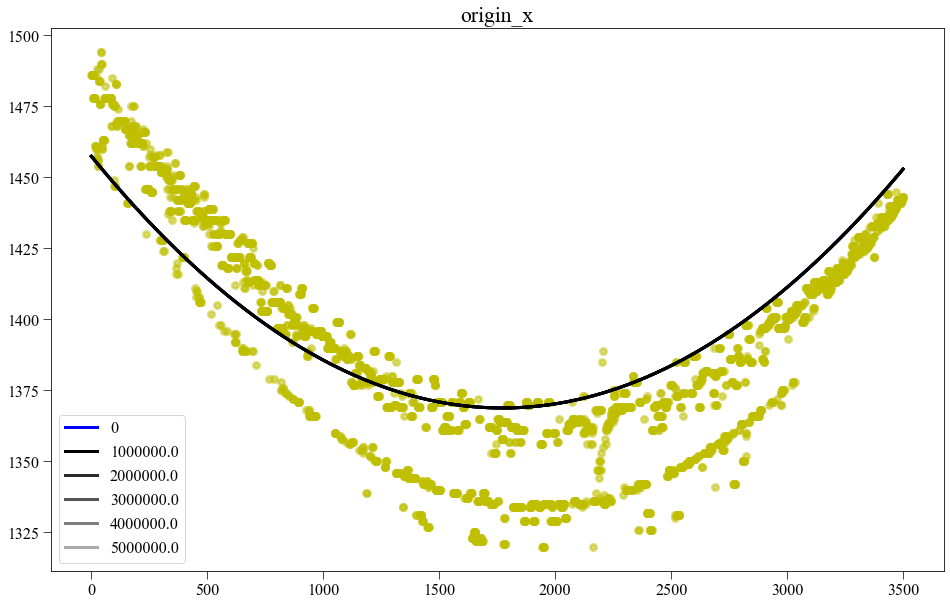

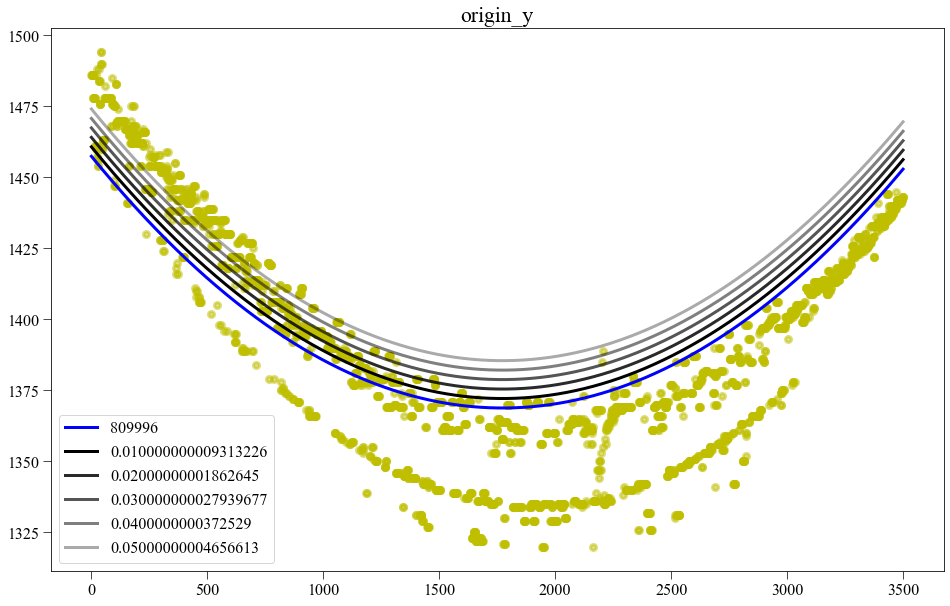

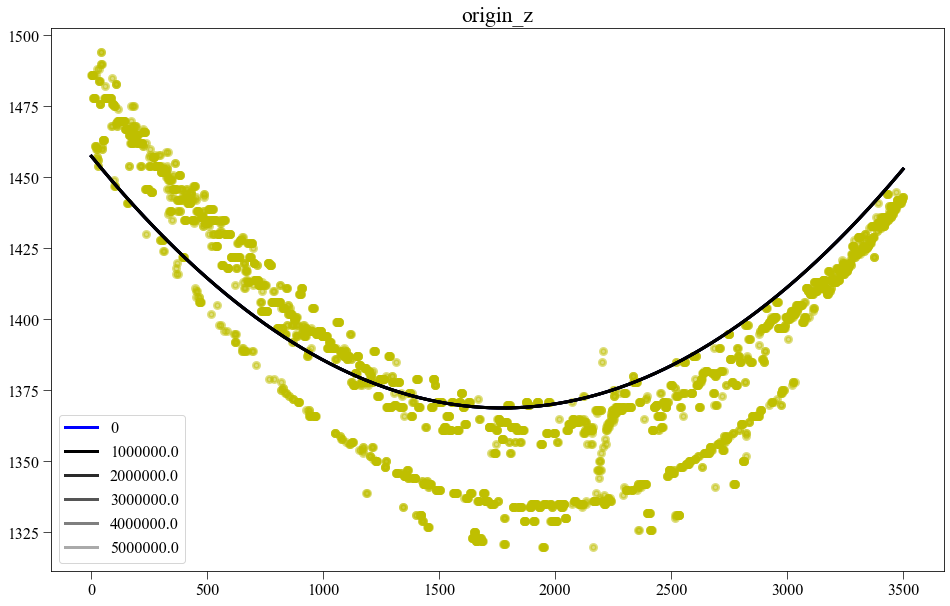

In [427]:
target = breaks[:3500]

inc = {'r': 10, 'h': 1e-2, 'f': 0.01,
       'px': 100, 'py': 1e-5,
       'x0': 0.001, 'y0': 1e-5,
       'theta_x': -1e-8, 'theta_y': 0.0001, 'theta_z': 0.0001,
       'origin_x': 1e6, 'origin_y': 1e-2, 'origin_z': 1e6}

init = full_init.copy()
# init = unpack_parameters(results.x, truncated_init)
# init = unpack_parameters(results.x, truncated_init)

y = cost_function.evaluate(init)

for key in init:
    plt.plot(x, y, lw=3, c='b', label=init[key])
    
    p = init.copy()
    for i in range(5):
        p[key] += inc[key]
        yp = cost_function.evaluate(p)
        plt.plot(x, yp, lw=3, c='k', alpha=(6.-i)/6, label=p[key]-init[key])
    
    plt.scatter(x, target, c='y', lw=3, alpha=0.5)
    plt.title(key)
    plt.legend()
    plt.show()
#     break
    

In [138]:
# resectioning 

target = breaks[:3500]
x = np.arange(len(target))

# y = limb_arc(x, r=earth_r, h=iss_h, method='resection',
#              f=1, px=1, py=3e-3, x0=0, y0=0,
#              theta_x=np.pi, theta_y=0, theta_z=2e-4,
#              origin_x=0, origin_y=809996, origin_z=0)
    
# # rough guess
# plt.plot(x, y, lw=3, c='k')
# plt.scatter(x, target, c='y', lw=3, alpha=0.5)
# plt.show()

def cost_function(r, h=iss_h,
                  f=1, px=1, py=3e-3, x0=0, y0=0,
                  theta_x=np.pi, theta_y=0, theta_z=2e-4,
                  origin_x=0, origin_y=809996, origin_z=0):
    if type(r) == np.ndarray:
        kwargs = unpack_parameters(list(r))
        y_pred = limb_arc(x, r=r, h=h,
                          f=f, px=px, py=py, x0=x0, y0=y0,
                          theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
                          origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)
    else:  
        y_pred = limb_arc(x, r=r, h=h,
                          f=f, px=px, py=py, x0=x0, y0=y0,
                          theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
                          origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)

    return np.sum(pow(y_pred - target, 2))
    
cost_function.errordef = Minuit.LEAST_SQUARES
# cost_function.errordef = Minuit.LIKELIHOOD

# m = Minuit(cost_function, r=earth_r, h=iss_h,
#            f=1, px=1, py=3e-3, x0=0, y0=0,
#            theta_x=np.pi, theta_y=0, theta_z=2e-4,
#            origin_x=0, origin_y=809996, origin_z=0)

# m = Minuit(cost_function, r=earth_r, h=iss_h,
#            f=1, px=1, py=1, x0=0, y0=0,
#            theta_x=np.pi, theta_y=0, theta_z=0,
#            origin_x=0, origin_y=0, origin_z=0)

best_fit = np.inf
for i in accepted.index:
    m = Minuit(cost_function, **dict(accepted.loc[i]))

    # m.fixed = False # release all parameters
    m.fixed["h"] = True
    # m.fixed["x0"] = True
    # m.fixed["y0"] = True
    m.fixed["theta_y"] = True

    m.limits["theta_x"] = (-np.pi, np.pi)
    # m.limits["theta_y"] = (-np.pi, np.pi)
    m.limits["theta_z"] = (-np.pi, np.pi)

    m.limits["f"] = (0, None)
    m.limits["px"] = (0, None)
    m.limits["py"] = (0, None)

    m.limits["r"] = (1e5, 1e8)
    
    lims = m.limits.to_dict()
    bounds = [lims[key] for key in lims]
    
    m.print_level = 2
#     m._tolerance = 1e-5
#     m._strategy = 2
    # m.errordef = 1
    # m.tol = 1e-7

#     m.simplex(ncall=int(1e6))  # run optimiser
    m.scipy(method='L-BFGS-B', constraints=bounds)
    print(m.values)

    m.hesse()   # run covariance estimator
#     print(m.errors)

    fit = m.values.to_dict()
#     print(fit)

#     m.fmin
    
    if m.fmin.fval < best_fit:
        best_fit = m.fmin.fval
        print('new best', best_fit)
        best_params = fit
    break

ValueError: setting constraints with dicts is not supported, use LinearConstraint or NonlinearConstraint from scipy.optimize.

In [108]:
m.values

<ValueView r=19763274.615126304 h=419714.0827806502 f=0.21730759665505556 px=31.25029838038878 py=10.36880646697765 x0=1042.3285702805817 y0=0.01500967994514131 theta_x=0.9469603625592676 theta_y=-1.0479108197510998 theta_z=-0.2738949110531303 origin_x=-620.9432730709984 origin_y=-606.0062349529952 origin_z=48.26593325799658>

In [110]:
fit = best_params

In [112]:
best_params

{'r': 7920834.652202488,
 'h': 418586.1088159861,
 'f': 8.530522075939547,
 'px': 1.725857643533023,
 'py': 2.124577359980054,
 'x0': -56.09014243752385,
 'y0': -30.62002423682569,
 'theta_x': 2.762978433618872,
 'theta_y': -1.9371893373944251,
 'theta_z': -2.109996077116671,
 'origin_x': -69.29827881279968,
 'origin_y': 104.97689481185708,
 'origin_z': -25.013438179776657}

In [279]:
fit['r'], earth_r

(6300005.747407524, 6300000.0)

In [280]:
fit

{'r': 6300005.747407524,
 'h': 417999.99999965896,
 'f': 1.0001261958976397,
 'px': 1,
 'py': 0.0029873868369553456,
 'x0': 0,
 'y0': 2.763730317175087e-06,
 'theta_x': 0.7092422628913151,
 'theta_y': 0,
 'theta_z': 0.0019544327098167274,
 'origin_x': 0,
 'origin_y': 810007.178474241,
 'origin_z': 0}

In [284]:
full_init

{'r': 6300000.0,
 'h': 418000,
 'f': 1,
 'px': 1,
 'py': 0.003,
 'x0': 0,
 'y0': 0,
 'theta_x': 3.141592653589793,
 'theta_y': 0,
 'theta_z': 0.0003,
 'origin_x': 0,
 'origin_y': 809996,
 'origin_z': 0}

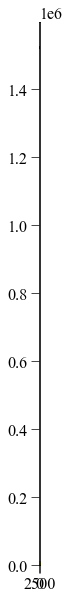

In [339]:
y = limb_arc(x, **fit)

plt.imshow(im_arr, origin='lower')
plt.plot(np.arange(len(target)), y, lw=3, c='b')
plt.scatter(np.arange(len(target)), target, c='y', lw=3, alpha=0.1)

# ABC

In [ ]:
from scipy.stats import multivariate_normal
from abcpy.probabilisticmodels import ProbabilisticModel, Continuous, InputConnector
from abcpy.continuousmodels import Uniform, Normal
from abcpy.statistics import Identity
from abcpy.distances import Euclidean, Distance
from abcpy.inferences import RejectionABC, APMCABC
from abcpy.backends import BackendDummy
from abcpy.backends import BackendMPI
import pyspark
sc = pyspark.SparkContext()
from abcpy.backends import BackendSpark

from scipy.spatial.distance import cdist

In [429]:
cost_function = CostFunction(x, target, limb_arc, truncated_init, full_init)

['r', 'h', 'f', 'py', 'y0', 'theta_x', 'theta_z', 'origin_y']

In [444]:
class LimbArc(ProbabilisticModel, Continuous):

    def __init__(self, parameters, fit_params_init, full_params_init, target, name='LimbArc'):
#         expecting [r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z]
        # expecting [r, h, f, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z]
        if not isinstance(parameters, list):
            raise TypeError('Input of Normal model is of type list')

        self.target = target
        self.num_x_pixels = len(target)
        self.cost_function = CostFunction(np.arange(self.num_x_pixels), target,
                                          limb_arc, fit_params_init, full_params_init)
        
        self.fit_params_init = fit_params_init
        self.full_params_init = full_params_init
        
        self.n_fit_params = len(fit_params_init.keys())
        if len(parameters) != self.n_fit_params:
            raise RuntimeError(f'Input list must be of length {self.n_fit_params},'\
                               f'containing {[key for key in fit_params_init]}.')

        input_connector = InputConnector.from_list(parameters)
        super().__init__(input_connector, name)

    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != self.n_fit_params:
            raise ValueError(f'Number of parameters of LimbArc model must be {self.n_fit_params}.')

        # Check whether input is from correct domain
#         r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z = input_values
        params = unpack_parameters(input_values, self.fit_params_init)
        if params['r'] < 0 or params['h'] < 0 or params['f'] < 0 or params['py'] <= 0:
            return False
                               
        return True

    def _check_output(self, values):
        if not isinstance(values, np.array):
            raise ValueError('This returns a bivariate array')
        
#         if values.shape[0] != 2: 
#             raise RuntimeError('The size of the output has to be 2.')
        
        return True

    def get_output_dimension(self):
#         return self.num_x_pixels
        return 2

    def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
        # Extract the input parameters
#         r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z = input_values
        
#         mean = np.array([m1, m2])
#         cov = self.get_cov(s1, s2, alpha)
        # might want to implement variations rather than completely deterministic 
        # right now we hack
        
#         obs_pd = multivariate_normal(mean=mean, cov=cov)
#         vector_of_k_samples = obs_pd.rvs(k)
#         obs = limb_arc(np.arange(self.num_x_pixels), r=r, h=h,
#                        f=f, px=px, py=py, x0=x0, y0=y0,
#                        theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
#                        origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)
    
        obs = self.cost_function.evaluate(unpack_parameters(input_values, self.fit_params_init))

        # Format the output to obey API
#         result = [np.array([x]) for x in vector_of_k_samples]
        obs = obs.reshape(1, len(obs))
        result = [obs for _ in range(k)]
        return result

In [435]:
class Cosine(Distance):
    """
    This class implements the Cosine distance between two vectors.
    The maximum value of the distance is np.inf.
    Parameters
    ----------
    statistics_calc : abcpy.statistics.Statistics
        Statistics extractor object that conforms to the Statistics class.
    """

    def __init__(self, statistics_calc):
        super(Cosine, self).__init__(statistics_calc)

    def distance(self, d1, d2):
        """Calculates the distance between two datasets, by computing Cosine distance between each element of d1 and
        d2 and taking their average.
        Parameters
        ----------
        d1: Python list
            Contains n1 data points.
        d2: Python list
            Contains n2 data points.
        Returns
        -------
        numpy.float
            The distance between the two input data sets.
        """
        s1, s2 = self._calculate_summary_stat(d1, d2)

        # compute distance between the statistics
        dist = np.zeros(shape=(s1.shape[0], s2.shape[0]))
        for ind1 in range(0, s1.shape[0]):
            for ind2 in range(0, s2.shape[0]):
                dist[ind1, ind2] = cdist(s1[ind1, :].reshape(1,s1.shape[1]),
                                         s2[ind2, :].reshape(1,s2.shape[1]))

        return dist.mean()


    def dist_max(self):
        """
        Returns
        -------
        numpy.float
            The maximal possible value of the desired distance function.
        """
        return np.inf

In [436]:
truncated_init

{'r': 6300000.0,
 'h': 418000,
 'f': 1,
 'py': 0.1,
 'y0': 0,
 'theta_x': 3.141592653589793,
 'theta_z': 0,
 'origin_y': 809996}

In [440]:
results.x

array([ 6.44724725e+06,  4.15331063e+05,  1.85513247e+00,  4.04060753e-03,
       -1.05684923e-04,  3.14159265e+00,  3.18200741e-04,  8.05528515e+05])

In [449]:
fit_vals

[1000000.000000028,
 418000.0319895745,
 1.0000000000104554,
 1,
 0.0029999862803833663,
 0,
 45.705217574519494,
 3.141592653589793,
 0,
 0.0003000000041387631,
 0,
 809995.9785185865,
 0]

In [468]:
r = Normal([[6358298], [1000000]], name="radius")
h = Normal([[418000], [1000]], name="height")

f = Uniform([[0], [100]], name="focal_length")
# px = Uniform([[0], [5]], name="pixel_width_x")
py = Uniform([[1e-5], [1]], name="pixel_width_y")

# x0 = Uniform([[-100], [100]], name="image_center_x")
y0 = Uniform([[-1], [1]], name="image_center_y")
theta_x = Uniform([[-np.pi], [np.pi]], name="rotation_x")
# theta_y = Uniform([[-np.pi], [np.pi]], name="rotation_y")
theta_z = Uniform([[-np.pi], [np.pi]], name="rotation_z")
# origin_x = Uniform([[-100], [100]], name="world_origin_x")
origin_y = Uniform([[-1000000], [1000000]], name="world_origin_y")
# origin_z = Uniform([[-100], [100]], name="world_origin_z")


# LA = LimbArc([r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z,
#              origin_x, origin_y, origin_z], num_x_pixels=len(target))
LA = LimbArc([r, h, f, py, y0, theta_x, theta_z, origin_y],
             truncated_init, full_init, target,
             name='LimbArc')

# sim = LA.forward_simulate(list(truncated_init.values()), 1)
sim = LA.forward_simulate(list(unpack_parameters(results.x, truncated_init).values()), 1)

In [469]:
sim

[array([[1491.09577185, 1490.94971668, 1490.80373741, ..., 1443.68549208,
         1443.80450832, 1443.92360041]])]

In [49]:
# def unpack_parameters(params):
#     r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z = params
    
#     return {'r':r, 'h':h, 'f':f, 'px':px, 'py':py, 'x0':x0,
#             'y0':y0, 'theta_x':theta_x, 'theta_y': theta_y,
#             'theta_z':theta_z, 'origin_x':origin_x, 'origin_y':origin_y,
#             'origin_z':origin_z}

In [18]:
sim

[array([[1412.75658246, 1412.73965676, 1412.72273106, ..., 1353.56563521,
         1353.54870849, 1353.53178177]])]

In [454]:
statistics_calculator = Identity()
distance_calculator = Euclidean(statistics_calculator)
# distance_calculator = Cosine(statistics_calculator)
# backend = BackendDummy()
backend = BackendSpark(sc, parallelism=4)
# backend = BackendMPI(process_per_model=1)

In [455]:
obs = target.reshape(1, len(target))

In [471]:
distance_calculator.distance([obs], sim)

794.5990477768139

In [457]:
sim[0].sum()/10.

16384.348416124318

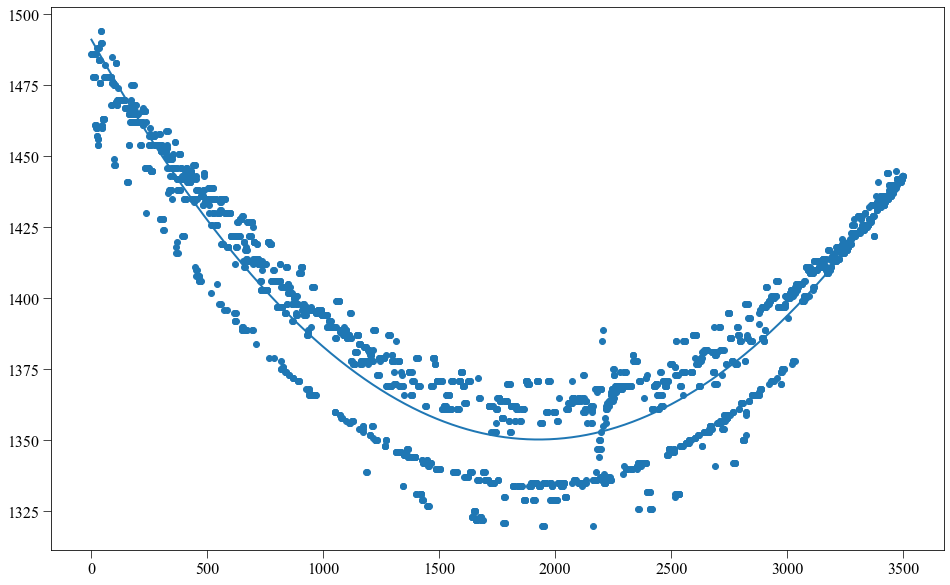

In [470]:
plt.scatter(x, obs[0])
plt.plot(x, sim[0][0])

In [458]:
sampler = RejectionABC([LA], [distance_calculator], backend, seed=1)

In [459]:
n_samples = 50  # number of posterior samples we aim for
n_samples_per_param = 1  # number of simulations for each set of parameter values
journal = sampler.sample([[target.reshape(1, len(target))]],
                         n_samples, n_samples_per_param, epsilon=100000)

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 4) / 4]
Traceback (most recent call last):
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/banderson/.pyenv/versions/3.9.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [460]:
journal.number_of_simulations

[5881063]

In [43]:
posterior_samples = np.array(journal.get_accepted_parameters()).squeeze()

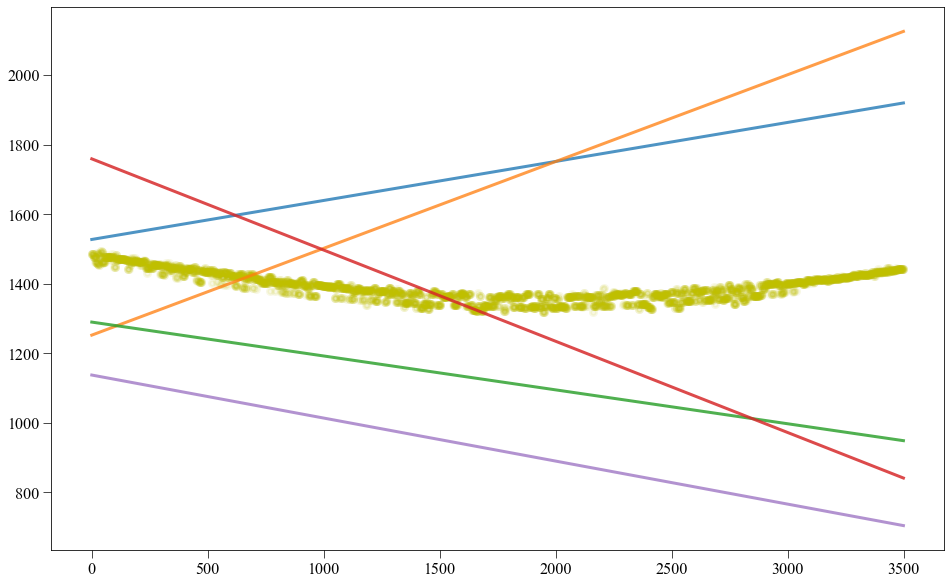

In [63]:
# plt.imshow(im_arr, origin='lower')
plt.scatter(np.arange(len(target)), target, c='y', lw=3, alpha=0.1)

for sample in posterior_samples:
    d = distance_calculator.distance([obs], LA.forward_simulate(list(sample), 1))
#     print(d)
    if d > 30000:
        continue
    arc = LA.forward_simulate(list(sample), k=1)[0][0]
    plt.plot(np.arange(len(arc)), arc, lw=3, alpha=1-d/100000.)
    
plt.show()

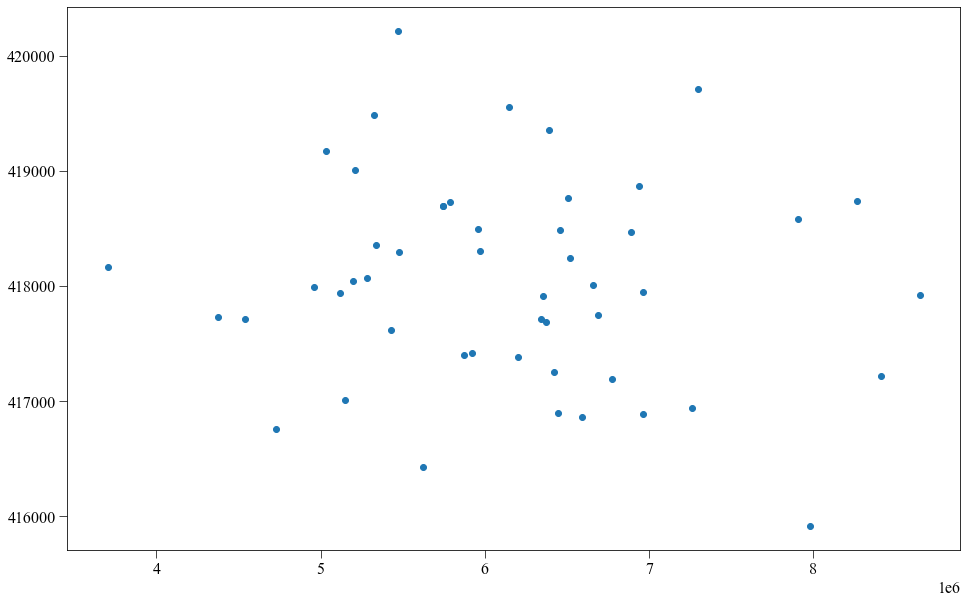

In [53]:
accepted = []
for sample in posterior_samples:    
    accepted += [unpack_parameters(sample)]
accepted = pd.DataFrame.from_records(accepted)
plt.scatter(accepted['r'], accepted['h'])
plt.show()

In [55]:
accepted.describe()

,r,h,f,px,py,x0,y0,theta_x,theta_y,theta_z,origin_x,origin_y,origin_z
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.147749e+06,418040.427196,2.422957,2.454792,3.369405,-1.365437,-0.413897,0.214122,-0.467486,-0.143983,-7.201313,-9.515595,-5.002140
std,1.048171e+06,893.535636,2.346489,1.350541,1.115276,63.361500,5.120992,1.708678,1.733456,1.710547,54.706432,60.470894,59.643636
min,3.705437e+06,415917.543524,0.030372,0.076735,1.404150,-99.979115,-31.263442,-2.889037,-3.072007,-3.052553,-92.117026,-90.347670,-95.115131
25%,5.360352e+06,417402.860834,0.645268,1.589505,2.371141,-52.152930,-0.965625,-1.182787,-1.761631,-1.313290,-52.875593,-59.649896,-52.490264
50%,6.173623e+06,418003.075179,1.567277,2.576106,3.659812,-8.727904,-0.162737,0.247100,-0.991823,-0.263792,-12.276449,-25.359759,-10.331187
75%,6.683054e+06,418668.430363,3.445657,3.320157,4.345753,65.468055,0.534681,1.872627,0.845298,1.397448,43.351888,35.638531,39.900017
max,8.646688e+06,420212.687498,8.572281,4.944056,4.880486,99.053312,10.255099,2.871732,2.945442,3.047351,98.933546,98.826459,93.216006


In [72]:
accepted.to_csv('mc_accepted.csv', index=False)

In [48]:
r = Normal([[6358298], [1000000]], name="radius")
h = Normal([[418000], [1000]], name="height")

f = Uniform([[0], [10]], name="focal_length")
px = Uniform([[0], [5]], name="pixel_width_x")
py = Uniform([[0], [5]], name="pixel_width_y")

x0 = Uniform([[-100], [100]], name="image_center_x")
y0 = Uniform([[-100], [100]], name="image_center_y")
theta_x = Uniform([[-np.pi], [np.pi]], name="rotation_x")
theta_y = Uniform([[-np.pi], [np.pi]], name="rotation_y")
theta_z = Uniform([[-np.pi], [np.pi]], name="rotation_z")
origin_x = Uniform([[-100], [100]], name="world_origin_x")
origin_y = Uniform([[-100], [100]], name="world_origin_y")
origin_z = Uniform([[-100], [100]], name="world_origin_z")

array([ 5.21049960e+06,  4.19005308e+05,  1.92241230e+00,  1.81166282e+00,
        2.47652655e+00,  9.85277732e+01,  7.55593631e-01, -4.30237075e-01,
        1.93667049e+00,  1.69799350e+00,  4.17994519e+01, -5.75829715e+01,
       -1.96084312e+01])

# PYRO

In [755]:
true_coefs = torch.tensor([[1.], [2.]])

data = torch.randn((2, 1))

dim = 1

labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()


def dummy(x, y, n=1):
    return 2*x + 5*y


def model(data):

#     coefs_mean = torch.zeros(dim)
    coeffs_mean = torch.zeros((2, dim))
    coeffs_std = torch.ones(2, dim)

#     coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
#     coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(2, dim)))

#     y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
    coeffs = pyro.sample('normal', dist.Normal(coeffs_mean, coeffs_std))
    y = pyro.sample('y', dummy(*coeffs), obs=labels)

    return y

# hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)

# mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)

# mcmc_run = mcmc.run(data)

# mcmc.get_samples()['beta'].mean()  
# # torch.tensor([ 0.9819,  1.9258,  2.9737])
# posterior = mcmc_run.marginal('beta').empirical['beta']
# posterior.mean  # doctest: +SKIP
# # tensor([ 0.9819,  1.9258,  2.9737])

hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=100)
mcmc.run(data)
mcmc.summary()
# posterior = mcmc_run.marginal('beta').empirical['beta']
# posterior.mean  # doctest: +SKIP

Warmup:   0%|                                                                                                                                 | 0/1100 [00:00, ?it/s]

AttributeError: 'Tensor' object has no attribute 'log_prob'

In [753]:
def dummy(x, y, n=1):
    return 2*x + 5*y

thing = pyro.sample('beta', dist.Normal(torch.zeros((2, dim)), torch.ones(2, dim)))
# x, y = thing
dummy(*thing)

tensor([-1.4693])

In [727]:
dist.Bernoulli(logits=(torch.zeros((2, dim)) * data).sum(-1)).sample()

tensor([0., 0.])

In [728]:
labels

tensor([0., 1.])

In [729]:
dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()

tensor([1., 1.])

In [756]:
true_coefs = torch.tensor([1., 2., 3.])
data = torch.randn(2000, 3)
dim = 3
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()
def model(data):
    coefs_mean = torch.zeros(dim)
    coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
    y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
    return y
hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=100)
mcmc.run(data)
mcmc.summary()
# mcmc_run = mcmc.run(data)
# posterior = mcmc.marginal('beta').empirical['beta']
# posterior.mean  # doctest: +SKIP
# tensor([ 0.9819,  1.9258,  2.9737])

Sample: 100%|███████████████████████████████████████| 1100/1100 [00:02, 538.48it/s, step size=5.92e-01, acc. prob=0.930]                                             


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      1.12      0.08      1.12      0.98      1.24    111.27      1.01
   beta[1]      2.04      0.10      2.04      1.87      2.20     43.13      1.00
   beta[2]      3.08      0.14      3.09      2.85      3.30     27.30      1.00

Number of divergences: 0


In [646]:
dist.Bernoulli(logits=(coefs * data).sum(-1))

NameError: name 'coefs' is not defined

In [627]:
import torch
from pyro.infer.mcmc.api import HMC, MCMC
import pyro.distributions as dist

In [618]:
import torch.distributions as dist

In [623]:
import pyro

In [644]:
y_pred = limb_arc(x, r=r, h=h,
                  f=f, px=px, py=py, x0=x0, y0=y0,
                  theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
                  origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)

NameError: name 'f' is not defined

In [633]:
target

array([1486, 1486, 1486, ..., 1443, 1443, 1443])